In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

Этот датасет включает полногеномный анализ копийности генов в 104 случаях аденокарциномы предстательной железы. Данные взяты на [сBioPortal](http://download.cbioportal.org/prad_mskcc_2014.tar.gz).

# Клиническое описание

In [61]:
data = pd.read_csv('./prad_mskcc_2014/data_clinical_patient.txt',
                   sep="\t", header=4)

In [37]:
data.head()

,PATIENT_ID,FOLLOW_UP_TIME_MONTHS,DFS_MONTHS,DFS_STATUS,METS_FREE_TIME_MONTHS,METASTATIC_DISEASE,OS_MONTHS,OS_STATUS,AGE,PSA,CLIN_T_STAGE,RADIATION_TREATMENT_NEOADJUVANT,ADJUVANT_CHEMO,ADJUVANT_HORMONE_THERAPY,RADIATION_TREATMENT_ADJUVANT,PATH_T_STAGE,SURGERY
0,PCA0318,107.2,104.675804,0:DiseaseFree,104.675747,Negative,107.2,1:DECEASED,56.691149,4.6,T2a,NaN,NaN,NaN,NaN,pT2b,Radical Prostatectomy
1,PCA0301,10.3,9.495074,0:DiseaseFree,9.495069,Negative,10.3,1:DECEASED,63.048574,3.66,T2b,NaN,NaN,NaN,NaN,T3a,Radical Prostatectomy
2,PCA0334,31.7,29.635146,0:DiseaseFree,29.635130,Negative,31.7,1:DECEASED,62.232677,4.4,T2b,NaN,NaN,NaN,Adjuvant XRT,T2c,Radical Prostatectomy
3,PCA0375,12.9,7.983748,0:DiseaseFree,7.983743,Negative,12.9,1:DECEASED,55.218154,2.05,T2a,NaN,NaN,NaN,NaN,pT2b,Radical Prostatectomy
4,PCA0314,97.2,4.763962,1:Recurred,66.662615,Positive,97.2,1:DECEASED,47.313810,8,T1c,NaN,CLIN_TRIAL,"AA,LHRH",NaN,T3b,Radical Prostatectomy


Медианный возраст - 58.2 лет.


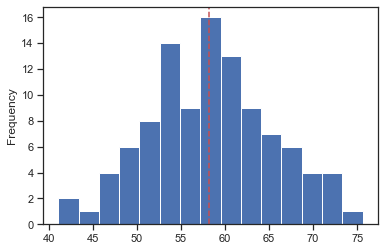

In [62]:
data['AGE'].plot(kind='hist', bins=15)
age_median = np.round(data['AGE'].median(), 1)
plt.axvline(age_median, color='r', linestyle='--')
print(f"Медианный возраст - {age_median} лет.")

Медианный уровень общей выживаемости - 70.1 месяцев


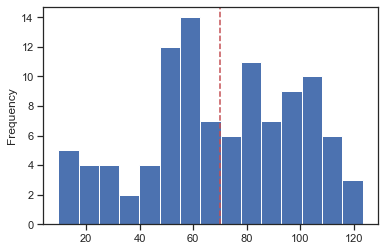

In [63]:
data['OS_MONTHS'].plot(kind='hist', bins=15)
mOS = np.round(data['OS_MONTHS'].median(), 1)
plt.axvline(mOS, color='r', linestyle='--')
print(f"Медианный уровень общей выживаемости - {mOS} месяцев")

Разделим на группы по стадии заболевания и сравним выживаемость между ними.

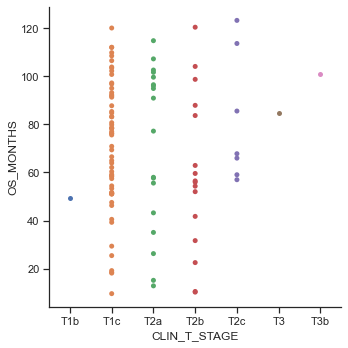

In [67]:
sns.catplot(x="CLIN_T_STAGE", y="OS_MONTHS", jitter=False,
            data=data, order=['T1b', 'T1c', 'T2a', 'T2b',
                                'T2c', 'T3', 'T3b'])

При визуальном анализе не прослеживается явного уменьшения общей выживаемости с ростом стадии.

Оценим наличие корреляции между PSA и общей выживаемостью.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Визуально связь не видна, коэффициент коррелляцииПирсона равен 0.109.


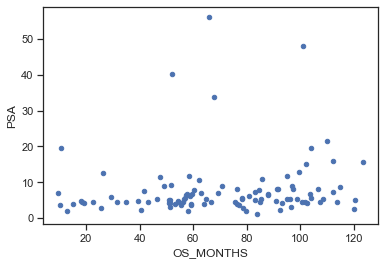

In [71]:
def convert_to_float(value):
    try:
        return float(value)
    except Exception as ex:
        return np.nan


data['PSA'] = data['PSA'].apply(convert_to_float)
ax2 = data.plot.scatter(y='PSA', x='OS_MONTHS')
corr_coef = data[['PSA', 'OS_MONTHS']].corr().values[0][1]
print(f"Визуально связь не видна, коэффициент коррелляции\
Пирсона равен {np.round(corr_coef,3)}.")

# Представление результатов анализа CNA

In [72]:
cna_data = pd.read_csv('./prad_mskcc_2014/data_CNA.txt', sep="\t", header=0)
cna_data.set_index('Hugo_Symbol', inplace=True)

Оценим гены, наиболее часто оказывающиеся амплифицированныи или делетированными.

In [78]:
aggregated_analytics = []
for i, row in cna_data.iterrows():
    amps = [value for value in row if value > 0]
    dels = [value for value in row if value < 0]
    n_amp = len(amps)
    n_del = len(dels)
    amp_freq = n_amp / row.shape[0]
    del_freq = n_del / row.shape[0]
    aggregated_analytics.append({'gene': row.name, 'n_amp': n_amp,
                                 'amp_freq': amp_freq,
                                'n_del': n_del, 'del_freq': del_freq})

aggregated_analytics_df = pd.DataFrame(aggregated_analytics)
aggregated_analytics_df.set_index('gene', inplace=True, drop=False)

n_genes = cna_data.shape[0]

amp_champ = aggregated_analytics_df['n_amp'].idxmax()
del_champ = aggregated_analytics_df['n_del'].idxmax()

amp_champ_freq = np.round(100*aggregated_analytics_df[aggregated_analytics_df
                                                      ['gene'] == amp_champ]
                          ['amp_freq'][0], 2)
del_champ_freq = np.round(100*aggregated_analytics_df[aggregated_analytics_df
                                                      ['gene'] == del_champ]
                          ['del_freq'][0], 2)

In [81]:
print(f'В таблице содержатся сведения по {n_genes} генам')
print(f'Наиболее часто амплифицированный ген в выборке: {amp_champ},\
встречается у {amp_champ_freq}% наблюдений')
print(f'Наиболее часто делетированный ген  в выборке: {del_champ}, встречается\
у {del_champ_freq}% наблюдений')

В таблице содержатся сведения по 24902 генам
Наиболее часто амплифицированный ген в выборке: OR11H1,встречается у 13.46% наблюдений
Наиболее часто делетированный ген  в выборке: KBTBD11, встречаетсяу 24.04% наблюдений


Теперь посмотрим на это с позиции отдельных пациентов, посмотрим на тех, у кого случается максимальное количество событий изменения копийности генов.

In [83]:
patients_data = []
for column in cna_data.columns:
    col = cna_data[column]
    n_cnas = len([value for value in col if value != 0])
    col['PATIENT_ID'] = col.name
    col['n_cnas'] = n_cnas
    patients_data.append(col)

patients_df = pd.concat(patients_data, axis=1).T

In [92]:
patients_df['n_cnas'].sort_values(ascending=False).head(30)

PCA0376    10665
PCA0300     4644
PCA0317     3926
PCA0378     3528
PCA0370     3426
PCA0339     3093
PCA0398     3079
PCA0336     2784
PCA0387     2729
PCA0368     2388
PCA0350     2366
PCA0332     2363
PCA0354     2084
PCA0404     1615
PCA0401     1573
PCA0392     1520
PCA0384     1514
PCA0311     1499
PCA0309     1447
PCA0338     1435
PCA0357     1317
PCA0345     1296
PCA0324     1266
PCA0323     1187
PCA0347     1186
PCA0402      895
PCA0395      877
PCA0318      842
PCA0307      800
PCA0302      685
Name: n_cnas, dtype: object

Видно, что абсолютным лидером является пациент PCA0376. Посмотрим на его клиническую картину.

In [86]:
data[data['PATIENT_ID'] == 'PCA0376']

,PATIENT_ID,FOLLOW_UP_TIME_MONTHS,DFS_MONTHS,DFS_STATUS,METS_FREE_TIME_MONTHS,METASTATIC_DISEASE,OS_MONTHS,OS_STATUS,AGE,PSA,CLIN_T_STAGE,RADIATION_TREATMENT_NEOADJUVANT,ADJUVANT_CHEMO,ADJUVANT_HORMONE_THERAPY,RADIATION_TREATMENT_ADJUVANT,PATH_T_STAGE,SURGERY
75,PCA0376,18.2,12.747712,0:DiseaseFree,12.747706,Negative,18.2,0:LIVING,44.244614,4.68,T1c,NaN,NaN,NaN,NaN,pT2b,Laparoscopic Prostatectomy


Интересно, что это случай неметастатического рака предстательной железы, относительно ранней стадии - pT2b, получивший хирургическое лечение и находящийся на момент отсечки в ремиссии.

Попробуем оценить коррелляцию между общей выживаемостью и числом перестроек.

In [89]:
data2 = data.merge(patients_df, left_on='PATIENT_ID', right_on='PATIENT_ID',
                   how='left')

In [90]:
data2['n_cnas'] = data2['n_cnas'].astype(float)

In [94]:
ax2 = data2.plot.scatter(y='n_cnas', x='OS_MONTHS')
corr_coef = data2['n_cnas'].corr(data2['OS_MONTHS'])
print(f"Визуально связь не видна, коэффициент коррелляции Пирсона равен\
{np.round(corr_coef,3)}. Наблюдается очень слабая отрицательная корреляция.")

Визуально связь не видна, коэффициент коррелляции Пирсона равен-0.1. Наблюдается очень слабая отрицательная корреляция.
